In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import sklearn
import scipy
import torch
import torchvision
import os
%matplotlib inline 

In [22]:
#Take sales of only one product for now
pd_bookstock= pd.read_csv('dataset_2019_01_24.csv')

df_p = pd_bookstock[pd_bookstock['base_product_number']==54046134]
print(df_p.columns)

Index(['retail_outlet_number', 'base_product_number', 'calendar_date',
       'calendar_hour', 'stock_count_shelf', 'stock_count_backroom',
       'book_stock_quantity', 'change', 'change_cause', 'min_bookstock',
       'max_bookstock', 'calculated_bookstock', 'change_cause_grouped'],
      dtype='object')


In [95]:
pd_bookstock['base_product_number'].unique()[15:20]
import warnings
warnings.filterwarnings('ignore')

In [130]:
pd_bookstock['base_product_number'].unique()[35:40]

array([54949978, 53842155, 53727085, 51487889, 52575017])

AxesSubplot(0.125,0.125;0.775x0.755)
6


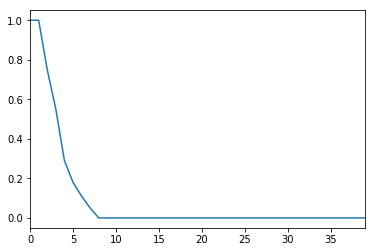

In [141]:
df_p = pd_bookstock[pd_bookstock['base_product_number']==52575017]
df_p_sales = df_p[df_p['change_cause']=='sales']
df_p_sales_per_day = df_p_sales.groupby('calendar_date')['change'].sum().reset_index()
df_p_sales_per_day.rename(columns = {'change':'sales'},inplace=True)
df_p_sales_max_bookstock = df_p_sales[['calendar_date','max_bookstock']].drop_duplicates()
df_p_sales_per_day_bookstock =df_p_sales_per_day.merge(df_p_sales_max_bookstock,on=['calendar_date'],how='left')
df_p_sales_per_day_bookstock['sales']= df_p_sales_per_day_bookstock['sales']*-1 

df_p_sales_per_day_bookstock['calendar_date']=pd.to_datetime(df_p_sales_per_day_bookstock['calendar_date'])

df_p_sales_per_day_bookstock=df_p_sales_per_day_bookstock.sort_values('calendar_date')
df_p_sales_per_day_bookstock = df_p_sales_per_day_bookstock.reset_index()
del df_p_sales_per_day_bookstock['index']
out_of_stock_per_to_fd = []

split_50 = int(len(df_p_sales_per_day_bookstock)*.5)
train = df_p_sales_per_day_bookstock.iloc[:split_50,:]

for fd in range(40):
    train['f_demand'] = fd
    train['stock_higher_than_f_demand'] = np.where(train['max_bookstock']>train['f_demand'],
                                                                          0,1)
    
    #print(fd,'days not enought stock = ',df_p_sales_per_day_bookstock['stock_higher_than_f_demand'].sum())
    #fix this bug
    #df_p_sales_per_day_bookstock = df_p_sales_per_day_bookstock[df_p_sales_per_day_bookstock['stock_higher_than_f_demand']==0]
    
    train['sales_above_f_demand'] = np.where(train['sales']>=train['f_demand'],
                                                                          1,0)
    above_fdemand = train['sales_above_f_demand'].value_counts()
    total_days = above_fdemand.sum()
    try:
        days_with_sales_above_fdemand = above_fdemand[above_fdemand.index==1].values[0]
    except:
        days_with_sales_above_fdemand=0
    
    out_of_stock_per_to_fd.append((fd,round(days_with_sales_above_fdemand/total_days,2)))
    
df_out_of_stock_per_to_fd = pd.DataFrame(out_of_stock_per_to_fd)

print (df_out_of_stock_per_to_fd[1].plot())
stock_optimized = df_out_of_stock_per_to_fd[0][df_out_of_stock_per_to_fd[1]>=.1].max()
print (stock_optimized)

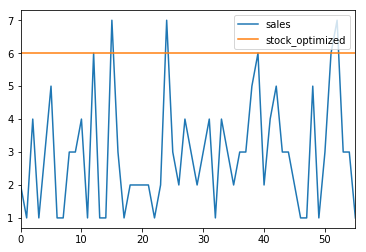

In [142]:
train['stock_optimized']=stock_optimized
train[['sales','stock_optimized']].plot()

AxesSubplot(0.125,0.125;0.775x0.755)
0.04


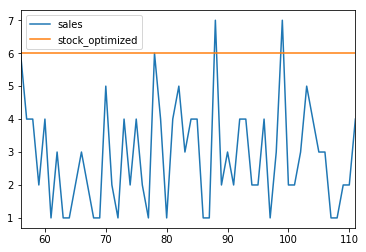

In [144]:
test = df_p_sales_per_day_bookstock.loc[split_50:,:]
total_day_test = float(len(test))
test['stock_optimized']=stock_optimized
print(test[['sales','stock_optimized']].plot())
days_above_stockoptimal = len(test[test['sales']>stock_optimized])
print(round(days_above_stockoptimal/total_day_test,2))


AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


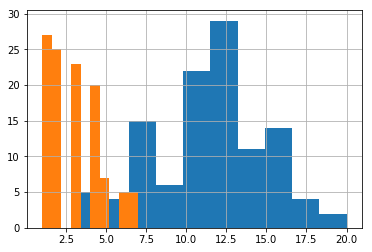

In [145]:
print(df_p_sales_per_day_bookstock['max_bookstock'].hist(),df_p_sales_per_day_bookstock['sales'].hist()

     )

In [21]:
per_day = df_p.groupby('calendar_date')['max_bookstock']>4.8

#df_p[df_p['max_bookstock']>4.8]

TypeError: '>' not supported between instances of 'SeriesGroupBy' and 'float'

In [5]:
print(df_p.columns) #copy-pasting column names from here to groupby() functions avoids KeyErrors

Index(['retail_outlet_number', 'base_product_number', 'calendar_date',
       'calendar_hour', 'stock_count_shelf', 'stock_count_backroom',
       'book_stock_quantity', 'change', 'change_cause', 'min_bookstock',
       'max_bookstock', 'calculated_bookstock', 'change_cause_grouped'],
      dtype='object')


In [6]:
#Take only entries that have change_cause as 'sales'
sales_df_p = df_p[df_p['change_cause']=='sales'].reset_index()
#print(sales_df_p)

#sum up all sales within a particular day for all days. This gives per day sales for product 54046134 for all days
# Note that the total data for this product is for 142 days
sum_change = sales_df_p.groupby('calendar_date')['change'].sum().reset_index()
#print(sum_change)
sum_change['change'] = sum_change['change']*-1 #make the sales numbers positive

##################################################
#Additional info:
size_days = np.size(sum_change['calendar_date'])
mean_sales = sum_change['change'].mean()
print("Total number of days of sales data:", size_days)
print("Average number of sales per day:",mean_sales) #calculating average sales per day
###################################################

#rename the column from 'change' to 'sales'
sum_change.rename(columns={list(sum_change)[1]:"sales"}, inplace = True) # can successfully rename column here

print(sum_change)

training_dt = sum_change.head(71) #create the training dataset of upper half entries
testing_dt = sum_change.tail(71) #testing dataset of bottom half entries

#CREATE LABELS for all sales numbers
#label 0: all units of the product will be sold, 
#label 1: all units of product won't be sold with a prob of at least 90%
all_labels=[]
for a in range(np.size(sum_change['sales'])):
    if(sum_change['sales'][a]<5):
        all_labels.append('0')
    else:
        all_labels.append('1')

#NOTE: The threshold is selected at 5 because for the product 54046134, the at least 90% of its units are sold
#...after selling 643 units in a span of 142 days. Hence, 643/142 = 4.52 = ~5 units per day
#print(all_labels)

Total number of days of sales data: 142
Average number of sales per day: 4.887323943661972
    calendar_date  sales
0      01/06/2018      9
1      01/07/2018      2
2      01/09/2018      5
3      01/10/2018      5
4      02/06/2018      9
5      02/09/2018      2
6      02/10/2018     10
7      03/06/2018      8
8      03/07/2018      4
9      03/08/2018      2
10     03/09/2018      5
11     03/10/2018      4
12     04/06/2018      3
13     04/07/2018      4
14     04/08/2018      6
15     04/09/2018      6
16     04/10/2018     11
17     05/06/2018      7
18     05/07/2018      4
19     05/08/2018      2
20     05/10/2018      9
21     06/06/2018     10
22     06/07/2018     10
23     06/08/2018      2
24     06/09/2018      1
25     06/10/2018      5
26     07/06/2018      1
27     07/07/2018      3
28     07/08/2018      9
29     07/09/2018      6
..            ...    ...
112    24/10/2018      2
113    25/06/2018      1
114    25/07/2018      2
115    25/08/2018      6
116    25

### Create training and testing set (logistic regression using the long way)

In [7]:
#Create training set from the upper half of all entries in the dataframe
training_set_less = []
training_set_more = []
labels = []

for a in range(np.size(training_dt['calendar_date'])):
    if(training_dt['sales'][a]<5):
#        print(sum_change['sales'][a], sum_change['max_calcbk'][a])
        training_set_less.append((training_dt['sales'][a], '0'))
        labels.append('0')
    elif(training_dt['sales'][a]>=5):
#        print(sum_change['sales'][a], sum_change['max_calcbk'][a])
        training_set_more.append((training_dt['sales'][a], '1'))
        labels.append('1')

training_set_less = np.asarray(training_set_less) #contains values less than threshold of 5
training_set_more = np.asarray(training_set_more) #contains values greater than threshold of 5
labels = np.asarray(labels)

#NOTE: The threshold is selected at 5 because for the product 54046134, the at least 90% of its units are sold
#...after selling 643 units in a span of 142 days. Hence, 643/142 = 4.52 = ~5 units per day

#print(training_set_less)
#print(training_set_more)
#print(labels)

#######################################################################
#TESTING SET from the lower half of all entries in the dataframe

testingdt_sales_values= testing_dt['sales'].values 
print(testingdt_sales_values)

[ 4  3 13  2  9  2  4  4  1  6  2  7  5  4  9  1 13 12  1  5  2 13  3  4
  3  3  5  5  1  9  6 11  5  2  5  4  3  6  3  7  3  2  1  2  6  6  6  3
  6  5  4  5  2  6  3  4  4  9  4  2  2  4  6  5  2  6  5  3  2  5  3]


### visualizing the training data

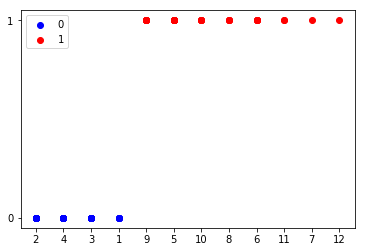

In [17]:
plt.scatter(training_set_less[:,0], training_set_less[:,1], color='b', label='0')
plt.scatter(training_set_more[:,0], training_set_more[:,1], color='r', label='1')
plt.legend();
#sort the X-axis

### final preparation of the data and labels

In [18]:
from sklearn.linear_model import LogisticRegression

joint_training = np.concatenate((training_set_less, training_set_more), axis=0) #join both arrays
training_data=joint_training[:,0] #this is the training data
training_labels=joint_training[:,1] #the corresponding labels
print(training_data)
print(training_labels)
#print(np.size(data))
#print(data[:,None])

#the numbers should be in int/float not strings

['2' '2' '4' '2' '4' '3' '4' '4' '2' '2' '1' '1' '3' '2' '3' '2' '3' '2'
 '2' '4' '3' '4' '3' '3' '4' '4' '2' '3' '1' '3' '3' '2' '1' '4' '4' '4'
 '1' '4' '9' '5' '5' '9' '10' '8' '5' '6' '6' '11' '7' '9' '10' '10' '5'
 '9' '6' '11' '12' '5' '5' '8' '5' '9' '10' '9' '8' '9' '10' '5' '8' '6'
 '6']
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']


### fitting the model to labels

In [10]:
model = LogisticRegression(C=1e20) #C is the inverse of regularization
#print(model)

#Fit the training data to the labels
%time model.fit(training_data[:,None], training_labels)  #supply data in the form of a 2D array "data[:,None]" to fit(). 1D array gives an error

CPU times: user 5.51 ms, sys: 2.71 ms, total: 8.22 ms
Wall time: 7.58 ms


/Users/Ganesh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### testing the model

In [11]:
print(testingdt_sales_values)

pred_labels = model.predict(testingdt_sales_values[:,None])
print(pred_labels)
#model.predict(testingdt_sales_values[:,None])[0:5]

[ 4  3 13  2  9  2  4  4  1  6  2  7  5  4  9  1 13 12  1  5  2 13  3  4
  3  3  5  5  1  9  6 11  5  2  5  4  3  6  3  7  3  2  1  2  6  6  6  3
  6  5  4  5  2  6  3  4  4  9  4  2  2  4  6  5  2  6  5  3  2  5  3]
['0' '0' '1' '0' '1' '0' '0' '0' '0' '1' '0' '1' '1' '0' '1' '0' '1' '1'
 '0' '1' '0' '1' '0' '0' '0' '0' '1' '1' '0' '1' '1' '1' '1' '0' '1' '0'
 '0' '1' '0' '1' '0' '0' '0' '0' '1' '1' '1' '0' '1' '1' '0' '1' '0' '1'
 '0' '0' '0' '1' '0' '0' '0' '0' '1' '1' '0' '1' '1' '0' '0' '1' '0']


In [16]:
#the intercept in logistic regression is log of the odds value (remember the StatQuest video) on the Y-axis when
#...the corresponding x-value is 0

model.intercept_, model.coef_

#The coefficients are represented in terms of log(odds) graph (from StatQuest video on coefficients)

(array([-74.00621403]), array([[16.41247646]]))

### Confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

pred_labels = model.predict(testingdt_sales_values[:,None])

#print(confusion_matrix(training_labels, pred_labels))
print(confusion_matrix(pred_labels, training_labels))

print(classification_report(pred_labels, training_labels))

[[20 19]
 [18 14]]
              precision    recall  f1-score   support

           0       0.53      0.51      0.52        39
           1       0.42      0.44      0.43        32

   micro avg       0.48      0.48      0.48        71
   macro avg       0.48      0.48      0.48        71
weighted avg       0.48      0.48      0.48        71



### Logistic regression in short

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sum_change['sales'].values, all_labels, test_size = 0.3, random_state = 42, shuffle = True)

y_pred = model.predict (X_test[:,None])
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[25  0]
 [ 0 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        18

   micro avg       1.00      1.00      1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

